# Welcome to the 5-Minute mzQC interactive guides with python!
This python notebook will guide you through your first steps with writing your own mzQC in python. 

We will calculate a QC metric from our data, visualise it, put it in a controlled vocabulary  object, add some metadata about the ms-experiment the data came from, and finally create our first mzQC file! (We assume it is not the first time you get your feet wet with python, otherwise rather plan for 25 minutes.)

## Setting the scene
First, we need to install the mzQC python library. When outside of the python notebook, find out [here](https://github.com/MS-Quality-hub/pymzqc) how to install locally (spoiler: usually just `pip install pymzqc`).

In [2]:
!pip install pymzqc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
     |████████████████████████████████| 1.8 MB 47.4 MB/s 
  Created wheel for frozendict: filename=frozendict-1.2-py3-none-any.whl size=3166 sha256=fccb38820a36c1431556bff63f8bc98b4e3b599b6618cb29e5c2fbd165d48f96
  Stored in directory: /root/.cache/pip/wheels/68/17/69/ac196dd181e620bba5fae5488e4fd6366a7316dce13cf88776
Successfully built frozendict
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.0 which is incompatible.
dat

Then, we start right in by loading pymzqc (`from mzqc`). We'll also utilise some other libraries, too.
For example, we will use `requests` to load some data from the web. This we will use as the computational data basis for the 'QC' metric value we are calculating and later visualise in this python notebook.

In [3]:
from mzqc import MZQCFile as qc
import numpy as np
from io import StringIO
import requests
import matplotlib.pyplot as plt

# Get some input data from the interwebs
url = "https://raw.githubusercontent.com/percolator/percolator/master/data/percolator/tab/percolatorTab"
r = requests.get(url)
if r.ok:
    data = r.content.decode('utf8')

data = '\n'.join(data.split('\n')[2:])  # remove the nasty extra header row

The data is identification data from a yeast digest 2h gradient run, just before you would subject your findings to [percolator](https://github.com/percolator/percolator). We will take a closer look at the mass discrepancies of the found PSMs.

In [4]:
dm_source = np.loadtxt(StringIO(data), usecols=(2,3,4), delimiter='\t', dtype={'names': ('ScanNr','ExpMass', 'CalcMass'), 'formats': ('i4', 'f4', 'f4')})
dm = dm_source['CalcMass'] - dm_source['ExpMass']

## Visualising our data
It is good practice to have a look at the data with some basic visualisation. Next, we will plot the mass errors in a histogram.

[Text(0, 0.5, 'Frequency'), Text(0.5, 1.0, 'Delta Mass Histogram')]

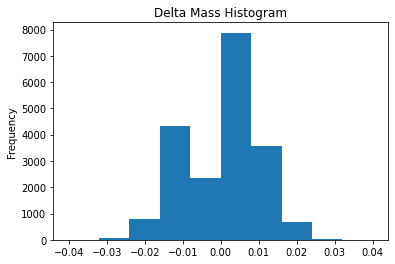

In [5]:
plt.hist(dm, bins=10)
plt.gca().set(title='Delta Mass Histogram', ylabel='Frequency')

The distribution seems centered around 0, which is good but the histogram has a rather wide bin setting, so we can check with another visualistation. Let's take a look at the violin plot of the absolute error.

[]

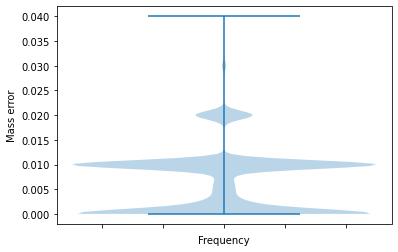

In [6]:
fig,ax = plt.subplots(1)

ax.violinplot(np.abs(dm))
# plt.violinplot(dm)

ax.set_ylabel('Mass error')
ax.set_xlabel('Frequency')

# Turn off x tick labels
ax.set_xticklabels([])

This looks suspicious, we better make some QC metrics to document that! We will describe the found distribution with $\sigma,Q_1,Q_2,Q_3$ and put it in a mzQC file to share with others.

## Creating our metrics

In [7]:
qm1 = qc.QualityMetric(accession="QC:0000000", name="Mass error sigma", value=np.std(dm))

q1,q2,q3 = np.quantile(dm, [0.25,0.5,0.75])
qm2 = qc.QualityMetric(accession="QC:0000000", name="Mass error Q1, Q2, Q3", value=(q1,q2,q3))

print("Mass error Q1={}, Q2={}, Q3={}, sigma={}".format(qm2.value[0],qm2.value[1],qm2.value[2],qm1.value))

Mass error Q1=-0.0098876953125, Q2=0.0, Q3=0.00299072265625, sigma=0.008799662813544273


Creating a controlled vocabulary defined metric in mzQC is easy! Look for the fitting entry in [our ontology](https://github.com/HUPO-PSI/mzQC/blob/master/cv/qc-cv.obo) or request a [new one](https://github.com/HUPO-PSI/mzQC/issues/new?assignees=julianu&labels=request+for+new+CV+entry&template=request-for-new-cv-entry.md&title=%5BCV+request%5D). Note the name and the accession, then set them as the `QualityMetric`s name and accession. We also need to keep a reference from which ontology this metric came from, so we note this as 'QC'. We will provide details about the ontologies used later. 
Setting the actual value of a metric is easy, just collect the values you calculated. (They have to be appropriate to the definition of the metric, though.)

## Keep track of your sources

In [8]:
infi_peak = qc.InputFile(name="file.raw",location="file:///dev/null/file.raw", 
                    fileFormat=qc.CvParameter(accession="MS:1000563", name="Thermo RAW format"), 
                    fileProperties=[qc.CvParameter(accession="MS:1000747", 
                                                    name="completion time", 
                                                    value="2015-10-03-T10:18:27Z"),
                            qc.CvParameter(accession="MS:1000569", 
                                            name="SHA-1", 
                                            value="76de62feccaaaadb608e89d897db57135e39ad87"
                            ),
                            qc.CvParameter(accession="MS:1000031", 
                                            name="instrument model",
                                            value="LTQ Orbitrap Velos"
                            )
            ])

It is crucial to provide some more information apart from the metrics themselves. To put the metrics into context, it is essential to keep track of the peak file or acquisition file that constitutes the basis to later data. In our case it is a thermo raw file from which we did the identifications from which we calculated our metric. We need to keep some more information about the origins file apart from the name:
 * the completion time
 * the checksum
 * the instrument type 

In [9]:
infi_ids = qc.InputFile(name="afteridbeforepercolat.tsv",location="file:///dev/null", 
                    fileFormat=qc.CvParameter(accession="MS:1000914", 
                                name="tab delimited text format"), 
                    )

We also want at least to know about the software that was involved in the process of creating the metrics. In our case that is the software that produced the identifications - comet, which has a PSI-MS cv term we can use, and obviously this python notebook.

In [10]:
anso_mzqc = qc.AnalysisSoftware(accession="MS:1002251", 
                                name="Comet",
                                version="2018.01.1", 
                                uri="http://proteomicsresource.washington.edu/sequest.php")
anso_nb = qc.AnalysisSoftware(version="0.1.2.3", uri="file:///mylocal/jupyter/host")

## Assemble a mzQC file (object)

Now we have all the neccessary information in place to build a descriptive object of the experiment and analysis for the mzQC file:

The `metadata`
* inputFiles
* analysisSoftware

and our `qualityMetrics`
* qm1
* qm2

In [11]:
meta = qc.MetaDataParameters(inputFiles=[infi_peak, infi_ids],analysisSoftware=[anso_mzqc,anso_nb])

rq = qc.RunQuality(metadata=meta, qualityMetrics=[qm1, qm2])

Now it is time to provide some more information about the ontologies which' terms we were using, so that the next one to read our file can look up the metric definitions, understand what the values mean, and use the data in further analysis.

In [12]:
cv_qc = qc.ControlledVocabulary(name="Proteomics Standards Initiative Quality Control Ontology",version="0.1.0", uri="https://github.com/HUPO-PSI/qcML-development/blob/master/cv/v0_1_0/qc-cv.obo")

cv_ms = qc.ControlledVocabulary(name="Proteomics Standards Initiative Mass Spectrometry Ontology",version="4.1.7", uri="https://github.com/HUPO-PSI/psi-ms-CV/blob/master/psi-ms.obo")

Finally we can put the last pieces together and form a mzQC file. We also note the current time in _ISO 8601 format_, the version of the mzQC format, we were writing. And so we made our first mzQC file.

In [13]:
from datetime import datetime
mzqc = qc.MzQcFile(version="1.0.0", creationDate=datetime.now().isoformat(), runQualities=[rq], setQualities=[], controlledVocabularies=[cv_qc, cv_ms])

With some extra python notebook _magic_, we can even download the fruit of our labour. (You need to execute all cells successfully in order to get the download link.)

In [14]:
from IPython.display import HTML
import base64
def download_mzqc(mzqc, title, filename):
    inmem_file = qc.JsonSerialisable.ToJson(mzqc)
    mzqc_b64 = base64.b64encode(inmem_file.encode())
    payload = mzqc_b64.decode()
    html = '<a download="{filename}" href="data:application/json;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

download_mzqc(mzqc, "our first mzqc file", "first.mzQC")